# Reference removal classifier

After some initial semantic chunking experiments, it became apparent that the reference list is included with the text of each article. Unfortunately, there is no section header or any other obvious formatting that could make it easy to remove the reference list. For some articles, as much as 1/3 of the text is references. We need a good way to remove them in the Wikipedia extraction phase or maybe in the semantic chunking phase - I could imagine wanting to do this with other data sources too. Either way, let's see what we can come up with. Here is the plan:

1. Split some articles into sentences and manually label them as 'text' or 'reference' to create training data.
2. Use Scikit-learn's TFIDF or count vectorizer to prepare the data
3. Train a classifier of some sort on it. My thought was XGBoost, but I have seen a few tutorials where people use a Multinomial Naive Bayes model (*sklearn.naive_bayes import MultinomialNB*)

Famous last words: sounds like it shouldn't be too hard....


## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import time
from pathlib import Path

# PyPI imports
import spacy
import h5py
import nltk
import pandas as pd
import syntok.segmenter as segmenter
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from xgboost import XGBClassifier

# Internal imports
import configuration as config

Working directory: /mnt/arkk/opensearch/semantic_search


In [2]:
# Set file paths
input_file=f'{config.DATA_PATH}/wikipedia/{config.BATCHED_TEXT}'
training_data_path=f'{config.DATA_PATH}/ref_removal_classifier'

# Get NLTK assets
Path(config.NLTK_ASSET_DIR).mkdir(parents=True, exist_ok=True)
nltk.download('punkt_tab', download_dir=config.NLTK_ASSET_DIR)

[nltk_data] Downloading package punkt_tab to /mnt/arkk/opensearch/sema
[nltk_data]     ntic_search/.venv/lib/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Sentence splitting method evaluation
Let's try and split some Wikipedia text into sentences. Of particular importance here will be how well each method can handle splitting the references we want to remove. We will try out three common methods:

1. [NLTK](https://www.nltk.org/api/nltk.tokenize.api.html#nltk.tokenize.api.TokenizerI.tokenize_sents)
2. [SpaCy](https://spacy.io/api/sentencizer)
3. [syntok](https://github.com/fnl/syntok/)

Also need to consider speed - we have a lot of articles to process.

In [3]:
# Open the hdf5 file and grab the first batch
input_data=h5py.File(input_file, 'r')
batch=input_data['batches/0']

# Number of records to test split
num_records=1000

# Holders for results
split_times = {}
sentences = {}

### 2.1 NLTK

In [4]:
%%time

# Get NLTK assets
Path(config.NLTK_ASSET_DIR).mkdir(parents=True, exist_ok=True)
nltk.download('punkt_tab', download_dir=config.NLTK_ASSET_DIR)
print()

# Holder for results
sentences['NLTK']=[]
split_times['NLTK']=[]

# Loop through records
for i, record in enumerate(batch[:num_records]):

    # Get the text string from bytes object
    record_text=record.decode('utf-8')

    # Start the timer
    start_time=time.time()

    # Apply sentence splitter
    nltk_sentences=nltk.tokenize.sent_tokenize(record_text)

    # Record the time
    split_times['NLTK'].append(time.time() - start_time)

    # Add the sentences to the result
    sentences['NLTK'].extend(nltk_sentences)

# Get mean split rate in records per second
nltk_split_rate=num_records / sum(split_times['NLTK'])
print(f'Mean nltk split rate: {nltk_split_rate:.0f} records per second\n')

[nltk_data] Downloading package punkt_tab to /mnt/arkk/opensearch/sema
[nltk_data]     ntic_search/.venv/lib/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Mean nltk split rate: 1468 records per second

CPU times: user 321 ms, sys: 19.3 ms, total: 341 ms
Wall time: 706 ms


### 2.2. SpaCy

In [5]:
%%time

# Load the model
nlp=spacy.load('en_core_web_sm')

# Holder for results
sentences['SpaCy']=[]
split_times['SpaCy']=[]

# Loop through records
for i, record in enumerate(batch[:num_records]):

    # Get the text string from bytes object
    record_text=record.decode('utf-8')

    # Start the timer
    start_time=time.time()

    # Ingest the record to Spacy
    record_text=nlp(record_text)

    # Apply sentence splitter
    spacy_sentences=[sent.text for sent in record_text.sents]

    # Record the time
    split_times['SpaCy'].append(time.time() - start_time)

    # Add the sentences to the result
    sentences['SpaCy'].extend(spacy_sentences)

# Get mean split rate in records per second
spacy_split_rate=num_records / sum(split_times['SpaCy'])
print(f'Mean Spacy split rate: {spacy_split_rate:.0f} records per second\n')

Mean Spacy split rate: 61 records per second

CPU times: user 16.3 s, sys: 875 ms, total: 17.2 s
Wall time: 18.8 s


### 2.3 syntok

In [6]:
%%time

# Holder for results
sentences['syntok']=[]
split_times['syntok']=[]

# Loop through records
for i, record in enumerate(batch[:num_records]):

    # Get the text string from bytes object
    record_text=record.decode('utf-8')

    # Start the timer
    start_time=time.time()

    paragraphs=segmenter.process(record_text)

    for paragraph in paragraphs:
        for sentence in paragraph:
            sentence_list=[]
            for token in sentence:
                sentence_list.append(token.value)

            sentences['syntok'].append(' '.join(sentence_list))

    # Record the time
    split_times['syntok'].append(time.time() - start_time)

# Get mean split rate in records per second
syntok_split_rate=num_records / sum(split_times['syntok'])
print(f'Mean syntok split rate: {syntok_split_rate:.0f} records per second\n')

Mean syntok split rate: 974 records per second

CPU times: user 1.03 s, sys: 378 μs, total: 1.03 s
Wall time: 1.03 s


### 2.4 Split rate results

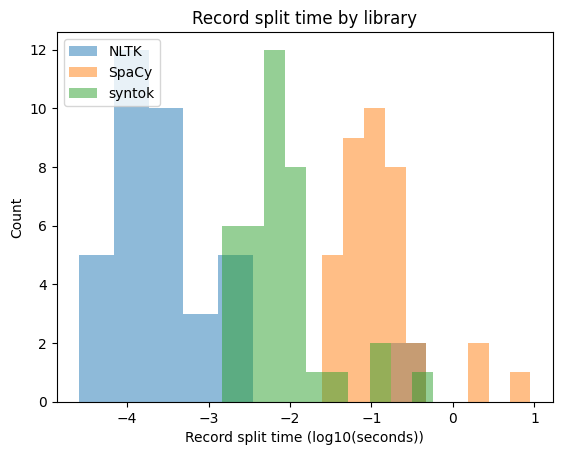

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.title('Record split time by library')

plt.hist(
    np.log10(split_times['NLTK']),
    #facecolor = 'green',
    label = 'NLTK',
    alpha = 0.5
)

plt.hist(
    np.log10(split_times['SpaCy']),
    #facecolor = 'blue',
    label = 'SpaCy',
    alpha = 0.5
)

plt.hist(
    np.log10(split_times['syntok']),
    #facecolor = 'blue',
    label = 'syntok',
    alpha = 0.5
)

plt.legend(loc = 'upper left')
plt.xlabel(f'Record split time (log10(seconds))')
plt.ylabel('Count')
plt.show()

### 2.5 Reference splitting performance
Let's take a look at how well each method did.

In [8]:
for splitter, split_sentences in sentences.items():

    print(f'Splitter: {splitter}\n')

    for i in range(5):
        print(f'{split_sentences[i]}\n')

    print()

Splitter: NLTK

This is a list of Chernobyl-related articles.

Comparison of Chernobyl and other radioactivity releases Comparison of the Chernobyl and Fukushima nuclear accidents Chernobyl disaster Effects of the Chernobyl disaster Chernobyl necklace Convention on Early Notification of a Nuclear Accident, adopted in direct response to Chernobyl Cultural impact of the Chernobyl disaster Deaths due to the Chernobyl disaster Individual involvement in the Chernobyl disaster List of Heroes of Ukraine — liquidators of the consequences of the Chernobyl disaster Radiophobia Threat of the Dnieper reservoirs Capture of Chernobyl Chernobyl Nuclear Power Plant Chernobyl Nuclear Power Plant sarcophagus Chernobyl New Safe Confinement Chernobyl exclusion zone, also known as the Zone of Alienation Pripyat, abandoned city Chernobyl, semi-abandoned city Kopachi, abandoned village Poliske, abandoned town Red Forest Slavutych, city established in 1986 after the disaster Elephant's Foot (Chernobyl), an ex

Ok, all look fine for text, but what about the reference list:

In [9]:
for splitter, split_sentences in sentences.items():

    print(f'Splitter: {splitter}\n')

    for i in range(340,350):
        print(f'{split_sentences[i]}\n')

    print()

Splitter: NLTK

Health bracelets and various healing jewelry such as ionized bracelets, hologram bracelets and magnetic jewelry, are purported to improve the health, heal, or improve the chi of the wearer.

No claims of effectiveness made by manufacturers have ever been substantiated by independent sources.

Hexagonal water – A term used in a marketing scam that claims the ability to create a certain configuration of water that is better for the body.

The term "hexagonal water" refers to a cluster of water molecules forming a hexagonal shape that supposedly enhances nutrient absorption, removes metabolic wastes and enhances cellular communication, among other things.

Similar to the dihydrogen monoxide hoax, the scam takes advantage of the consumer's limited knowledge of chemistry, physics and physiology.

Homeopathy – the belief that a patient with symptoms of an illness can be treated with extremely dilute remedies that are thought to produce those same symptoms in healthy people.



OK, so all the splitter libraries fail to split the references well. But, I don't think we actually need them too. They all split the reference section into small fragments, likely because of the abundance of punctuation. I think that can be our signal. If we just look at the character count of each sentence, when there is a run of short fragments all in a row, that is probably a reference section. Let's take a look on a plot:

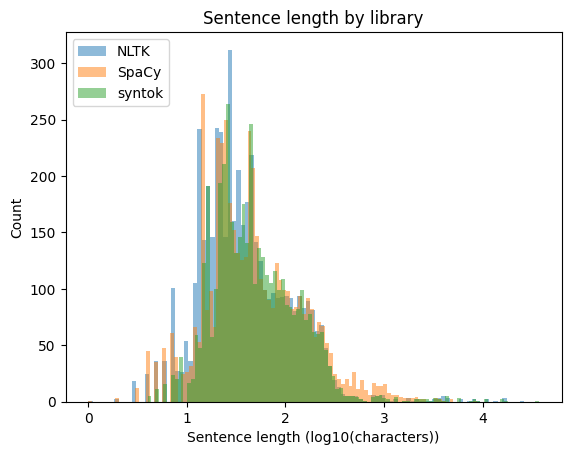

In [10]:
sentence_lengths={}

for library, sentence_list in sentences.items():
    sentence_lengths[library]=[]

    for sentence in sentence_list:
        sentence_length=len(sentence)
        sentence_lengths[library].append(sentence_length)

plt.title('Sentence length by library')

for library, lengths in sentence_lengths.items():

    plt.hist(
        np.log10(lengths),
        label=library,
        alpha=0.5,
        bins=100
    )

plt.legend(loc = 'upper left')
plt.xlabel(f'Sentence length (log10(characters))')
plt.ylabel('Count')
plt.show()

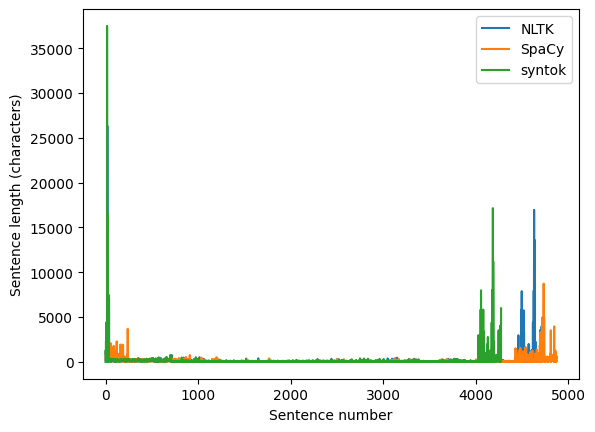

In [11]:
for library, lengths in sentence_lengths.items():
    plt.plot(range(len(lengths)), lengths, label=library)

plt.legend(loc='best')
plt.xlabel('Sentence number')
plt.ylabel('Sentence length (characters)')
plt.show()

Huh, OK, good plots - first thing that jumps out is the presence of some impossibly long sentences. We should probably be filtering those out. I wonder what they are.

Let's plot it again and zoom in a bit:

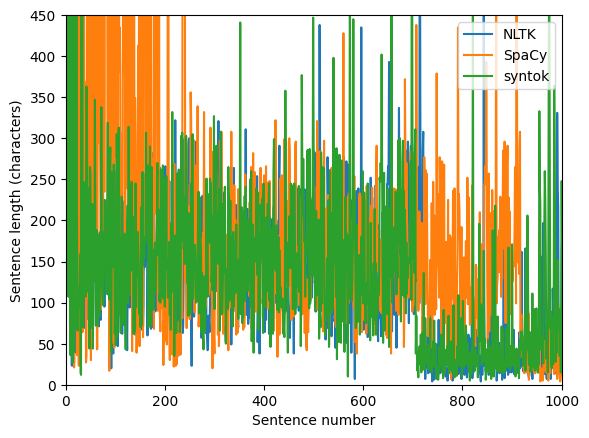

In [12]:
for library, lengths in sentence_lengths.items():
    plt.plot(range(len(lengths)), lengths, label=library)

plt.legend(loc='best')
plt.xlabel('Sentence number')
plt.ylabel('Sentence length (characters)')
plt.xlim(0,1000)
plt.ylim(0,450)
plt.show()

Yep, it's noisy, but I think I can see it. The reference list for the first article starts at a little before 340 sentences it, and we see a corresponding chunk of short fragments. Also, I don't see a convincing reason to use one or another of the splitter libraries. Stick with NLTK based on its speed alone. Now let's try smoothing the data with a moving average.

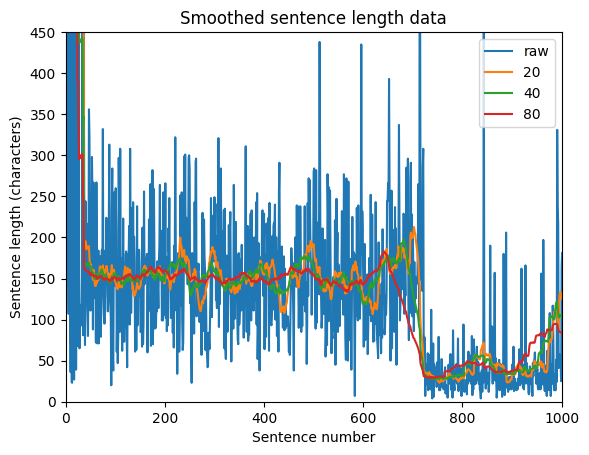

In [13]:
smoothed_sentence_lengths={
    'raw': sentence_lengths['NLTK']
}
smoothing_window_widths=[20, 40, 80]

for window_width in smoothing_window_widths:

    smoothed_data=np.convolve(sentence_lengths['NLTK'], np.ones(window_width)/window_width, mode='valid')
    smoothed_sentence_lengths[f'{window_width}']=smoothed_data

for window, data in smoothed_sentence_lengths.items():
    plt.plot(range(len(data)), data, label=window)

plt.title('Smoothed sentence length data')
plt.legend(loc='best')
plt.xlabel('Sentence number')
plt.ylabel('Sentence length (characters)')
plt.xlim(0,1000)
plt.ylim(0,450)
plt.show()

Ok, cool. A window of around 40 visually appears to be the sweet spot. But, I think we have a little more work to do here. I don't want to threshold the data at some arbitrary value. I think we should try and use an LSTM to learn to spot reference sections. This is a cool application because the order of the sequence of sentences matters, not just the length. We don't want to throw out short sentences from the middle of an article. The fragments we want to get rid of are:

1. Short
2. In a contiguous block
4. Always at the end of an article

I think we should be able to train an LSTM to do this if we take the time to manually label a bunch or articles. We would have one feature, the sentence length, and two classes for the output - text sentence and reference sentence.

## 2. Training data preparation

This is going to require some manual curation, but hopefully we will not need to many examples. Plan is to sentence split a few records, maybe start with 100, and save the sentence text and character length to a text fie. Then we can look at the file and label each row with a 0 or 1 for text sentence or reference sentence. Should be pretty easy and quick.

In [14]:
# Open the hdf5 file and grab the first batch
input_data=h5py.File(input_file, 'r')
batch=input_data['batches/0']

# Output file
output_file=f'{training_data_path}/training_data.csv'
with open(output_file, 'w') as output:

    # Loop through 100 records
    for i, record in enumerate(batch[:100]):

        # Get the text string from bytes object
        record_text=record.decode('utf-8')

        # Apply sentence splitter
        nltk_sentences=nltk.tokenize.sent_tokenize(record_text)

        # Write each sentence and it's length to the output
        for sentence in nltk_sentences:

            length=len(sentence)
            print(f'{length},{sentence}', file=output)

OK, went through up to record 30. Let's try with that. We have about 500 lines each of text and reference. Also notices along the way there were sever; 'disambiguation' pages and a few that were just a sentence or two about a movie: '_____ is a film by ____' and then a cast list. Maybe should be filtering those out too?

Next, we need to load the two training data files, add the labels, combine and shuffle them, train test split them and then vectorize.

In [15]:
# Load the reference and text sentences
with open(f'{training_data_path}/ref_sentences.txt') as file:
    ref_sentences=[line.rstrip() for line in file]

with open(f'{training_data_path}/text_sentences.txt') as file:
    text_sentences=[line.rstrip() for line in file]

# Create lists of labels
ref_labels=[1]*len(ref_sentences)
text_labels=[0]*len(text_sentences)

# Make dataframes
ref_df=pd.DataFrame({
    'sentence': ref_sentences,
    'label': ref_labels
})

text_df=pd.DataFrame({
    'sentence': text_sentences,
    'label': text_labels
})

# Concatenate
data_df=pd.concat([text_df, ref_df])

# Shuffle
data_df=data_df.sample(frac=1).reset_index(drop=True)

data_df.head(20)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/arkk/opensearch/semantic_search/data/ref_removal_classifier/ref_sentences.txt'

In [ ]:
# Train-test split
train_df, test_df = train_test_split(data_df, test_size=0.20, stratify=data_df.label)

# Vectorize with bag-of-words
# vec=CountVectorizer(
#     ngram_range=(1, 3),
#     stop_words='english',
# )

# Vectorize with TF-IDF
vec=TfidfVectorizer()

train_features = vec.fit_transform(train_df.sentence)
test_features = vec.transform(test_df.sentence)

train_labels = train_df.label
test_labels = test_df.label

## 3. Gaussian Naive Bayes

In [ ]:
model=GaussianNB()
model.fit(train_features.toarray(), train_labels)

predictions=model.predict(test_features.toarray())
print(classification_report(test_labels, predictions))

## 4. Multinomial Naive Bayes

In [ ]:
model=MultinomialNB()
model.fit(train_features.toarray(), train_labels)

predictions=model.predict(test_features.toarray())
print(classification_report(test_labels, predictions))

## 4. Gradient boosting decision tree

In [ ]:
model=XGBClassifier()
model.fit(train_features.toarray(), train_labels)

predictions=model.predict(test_features.toarray())
print(classification_report(test_labels, predictions))

## 5. Sanity check
XGBoost appears to be winning. Let's inspect some predictions and see how we are doing.

In [ ]:
for prediction, sentence in zip(predictions[:20], test_df['sentence'][:20]):
    print(f'{prediction}: {sentence}')

We can see some obvious misclassifications, for example:

```text
At low tide there are vast areas of mudflats and saltings, all teeming with birds.
```

Is definitely not a reference derived fragment, but on the whole we are doing pretty well. I would rather lose a sentence here or there than include more than 50% by reference list content.

I bet I could do better by using my train T5 to translate input text to 'reference' or 'not reference'....